In [25]:
'''
Import necessary packages
'''
import numpy as np
import scipy
import scipy.integrate
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import pickle
from tqdm import tqdm
from mpl_toolkits import mplot3d
import os
import math
import random
import proplot as pplt

# from ip3_ca_ode import *
from ip3_ca_ode_cfg import *
import cfg

save = 'figures/ip3_ca_experiments/'

#set figure font sizes for readability
pplt.rc.update({'font.size': 10})
color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

c_label = r'[Ca$^{2+}$]$_{cyt}$'
c_er_label = r'[Ca$^{2+}$]$_{ER}$'

In [26]:
def test_oscillation_delay_t(init=None, input_max=0.8, max_step=2):
    cfg.input_duration = 200
    cfg.input_max = input_max
    cfg.input_start = 0
    if init != None:
        cfg.all_init = init.copy()
    
    run_experiment('pulse', t_f=200, max_step=max_step)

    peaks = scipy.signal.find_peaks(cfg.c)[0]
    peaks = peaks[peaks > 10]
    first_peak = peaks[0]
    second_peak = peaks[1]
    troughs = scipy.signal.find_peaks(-cfg.c)[0]
    troughs = troughs[troughs > 10]
    first_trough = troughs[0]
    
    c_diff = cfg.c[second_peak] - cfg.c[first_trough]
    c_diff2 = cfg.c[peaks[2]] - cfg.c[troughs[1]]
    
    
    if (cfg.c[first_peak:] > 0.2).all():
        t_to_low_enough = cfg.t[-1]
        idx_to_low_enough = -1
        
    else:
        steps_to_02 = (cfg.c[first_peak:] < 0.2).argmax()
        t_to_low_enough = cfg.t[first_peak+steps_to_02]
        idx_to_low_enough = first_peak + steps_to_02
        
    return t_to_low_enough, idx_to_low_enough, c_diff, c_diff2


'''Poisson train input functions'''

def next_time(rate):
    return -math.log(1 - random.random()) / rate

def generate_train(rate, t_f=300):
    total_time = 0
    spikes = []
    while True:
        nxt = next_time(rate)
        total_time += nxt
        if total_time > t_f:
            return np.array(spikes)
        spikes.append(total_time)
    
    
def exponential_input(t):
    '''
    This function will generate an exponential increase and decay glutamate input
    '''
    input_half = cfg.input_duration / 2
    if(t > cfg.input_start and t <= (cfg.input_start + input_half)):
        return cfg.input_max * (1 - np.exp((t - cfg.input_start) / (t - cfg.input_start - input_half)))
    elif(t > (cfg.input_start + input_half) and t <= (cfg.input_start + cfg.input_duration)):
        return cfg.input_max * np.exp((t - cfg.input_start - input_half) / (t - cfg.input_start - cfg.input_duration))
    else:
        return cfg.input_min
    
    
def exponential_train(t):
    '''
    Get exponential input based on a Poisson spike train
    '''
    if t > np.max(cfg.train):
        idx = len(cfg.train) - 1
    else:
        idx = np.argmax(cfg.train > t) - 1
        if idx < 0:
            return cfg.input_min
#     print(idx)
    t = t - cfg.train[idx]
    return exponential_input(t)
    
def copy_init():
    cfg.all_init = [cfg.c[-1], cfg.c_tot[-1], cfg.h[-1], cfg.p[-1],
                    cfg.Gstar[-1], cfg.Gd1[-1], cfg.Gd2[-1], cfg.lamb[-1]]

# Initial condition effects

In [6]:
default_all_init = [0.09013785, 35.744397, 0.66821744, 0.040422910, 0.0, 0.0, 0.0, 0.0]

multipliers = np.linspace(0.7, 1.0, 31)

var_types = ['c', 'c_tot', 'h', 'p', 'Gstar', 'Gd1', 'Gd2', 'lambda']

z = []
ct = []
h = []
c_diffs = []
c_diffs2 = []
for mult1 in tqdm(multipliers):
    for mult2 in multipliers:
        test_init = default_all_init.copy()
        test_init[1] = test_init[1]*mult1 #c_tot
        test_init[2] = test_init[2]*mult2 #h
        
        t, _, c_diff, c_diff2 = test_oscillation_delay_t(test_init)
        z.append(t)
        c_diffs.append(c_diff)
        c_diffs2.append(c_diff2)
        ct.append(test_init[1])
        h.append(test_init[2])
    

shaped_z = np.flip(np.array(z).reshape(31, 31), axis=0)

mult_low = 0.7
mult_high = 1.0
h_default = 0.66821744
c_t_default = 35.744397

extent = (mult_low*h_default, mult_high*h_default,
                             mult_low*c_t_default, mult_high*c_t_default)

pickle.dump([shaped_z, extent], open('data/plot_data/oscillation_delay/1_h_ct_delays', 'wb'))

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:34<00:00,  1.10s/it]


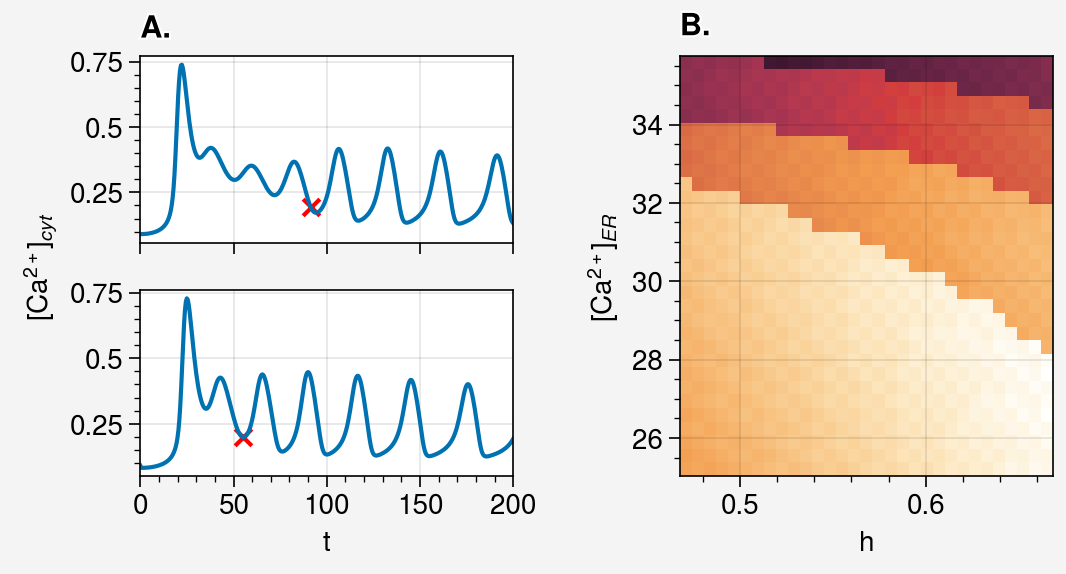

In [5]:
array = [
    [1, 1, 3, 3],
    [2, 2, 3, 3]
]

fig, ax = pplt.subplots(array, refaspect=2, wspace=6, sharex=False, figwidth=7)


set_init('default')
t_first, first, c_diff, c_diff2 = test_oscillation_delay_t(max_step=0.5)
ax[0].plot(cfg.t, cfg.c)
ax[0].scatter([cfg.t[first]], [cfg.c[first]], marker='x', c='red')

set_init('c_t')
t_first, first, c_diff, c_diff2 = test_oscillation_delay_t(max_step=0.5)
ax[1].plot(cfg.t, cfg.c)
ax[1].scatter([cfg.t[first]], [cfg.c[first]], marker='x', c='red')


shaped_z, extent = pickle.load(open('data/plot_data/oscillation_delay/1_h_ct_delays', 'rb'))
ax[2].imshow(shaped_z, extent=extent, aspect='auto')

ax[:2].format(xlabel='t', ylabel=c_label)
ax[2].format(xlabel='h', ylabel=c_t_label)
ax[0].format(xlabel='', xticklabels=[])

add_abc_to_subaxes(ax[0], top=1.1)
add_abc_to_subaxes(ax[2], 'B.')

# Poisson stimulation

**Visual example of poisson stimulation**

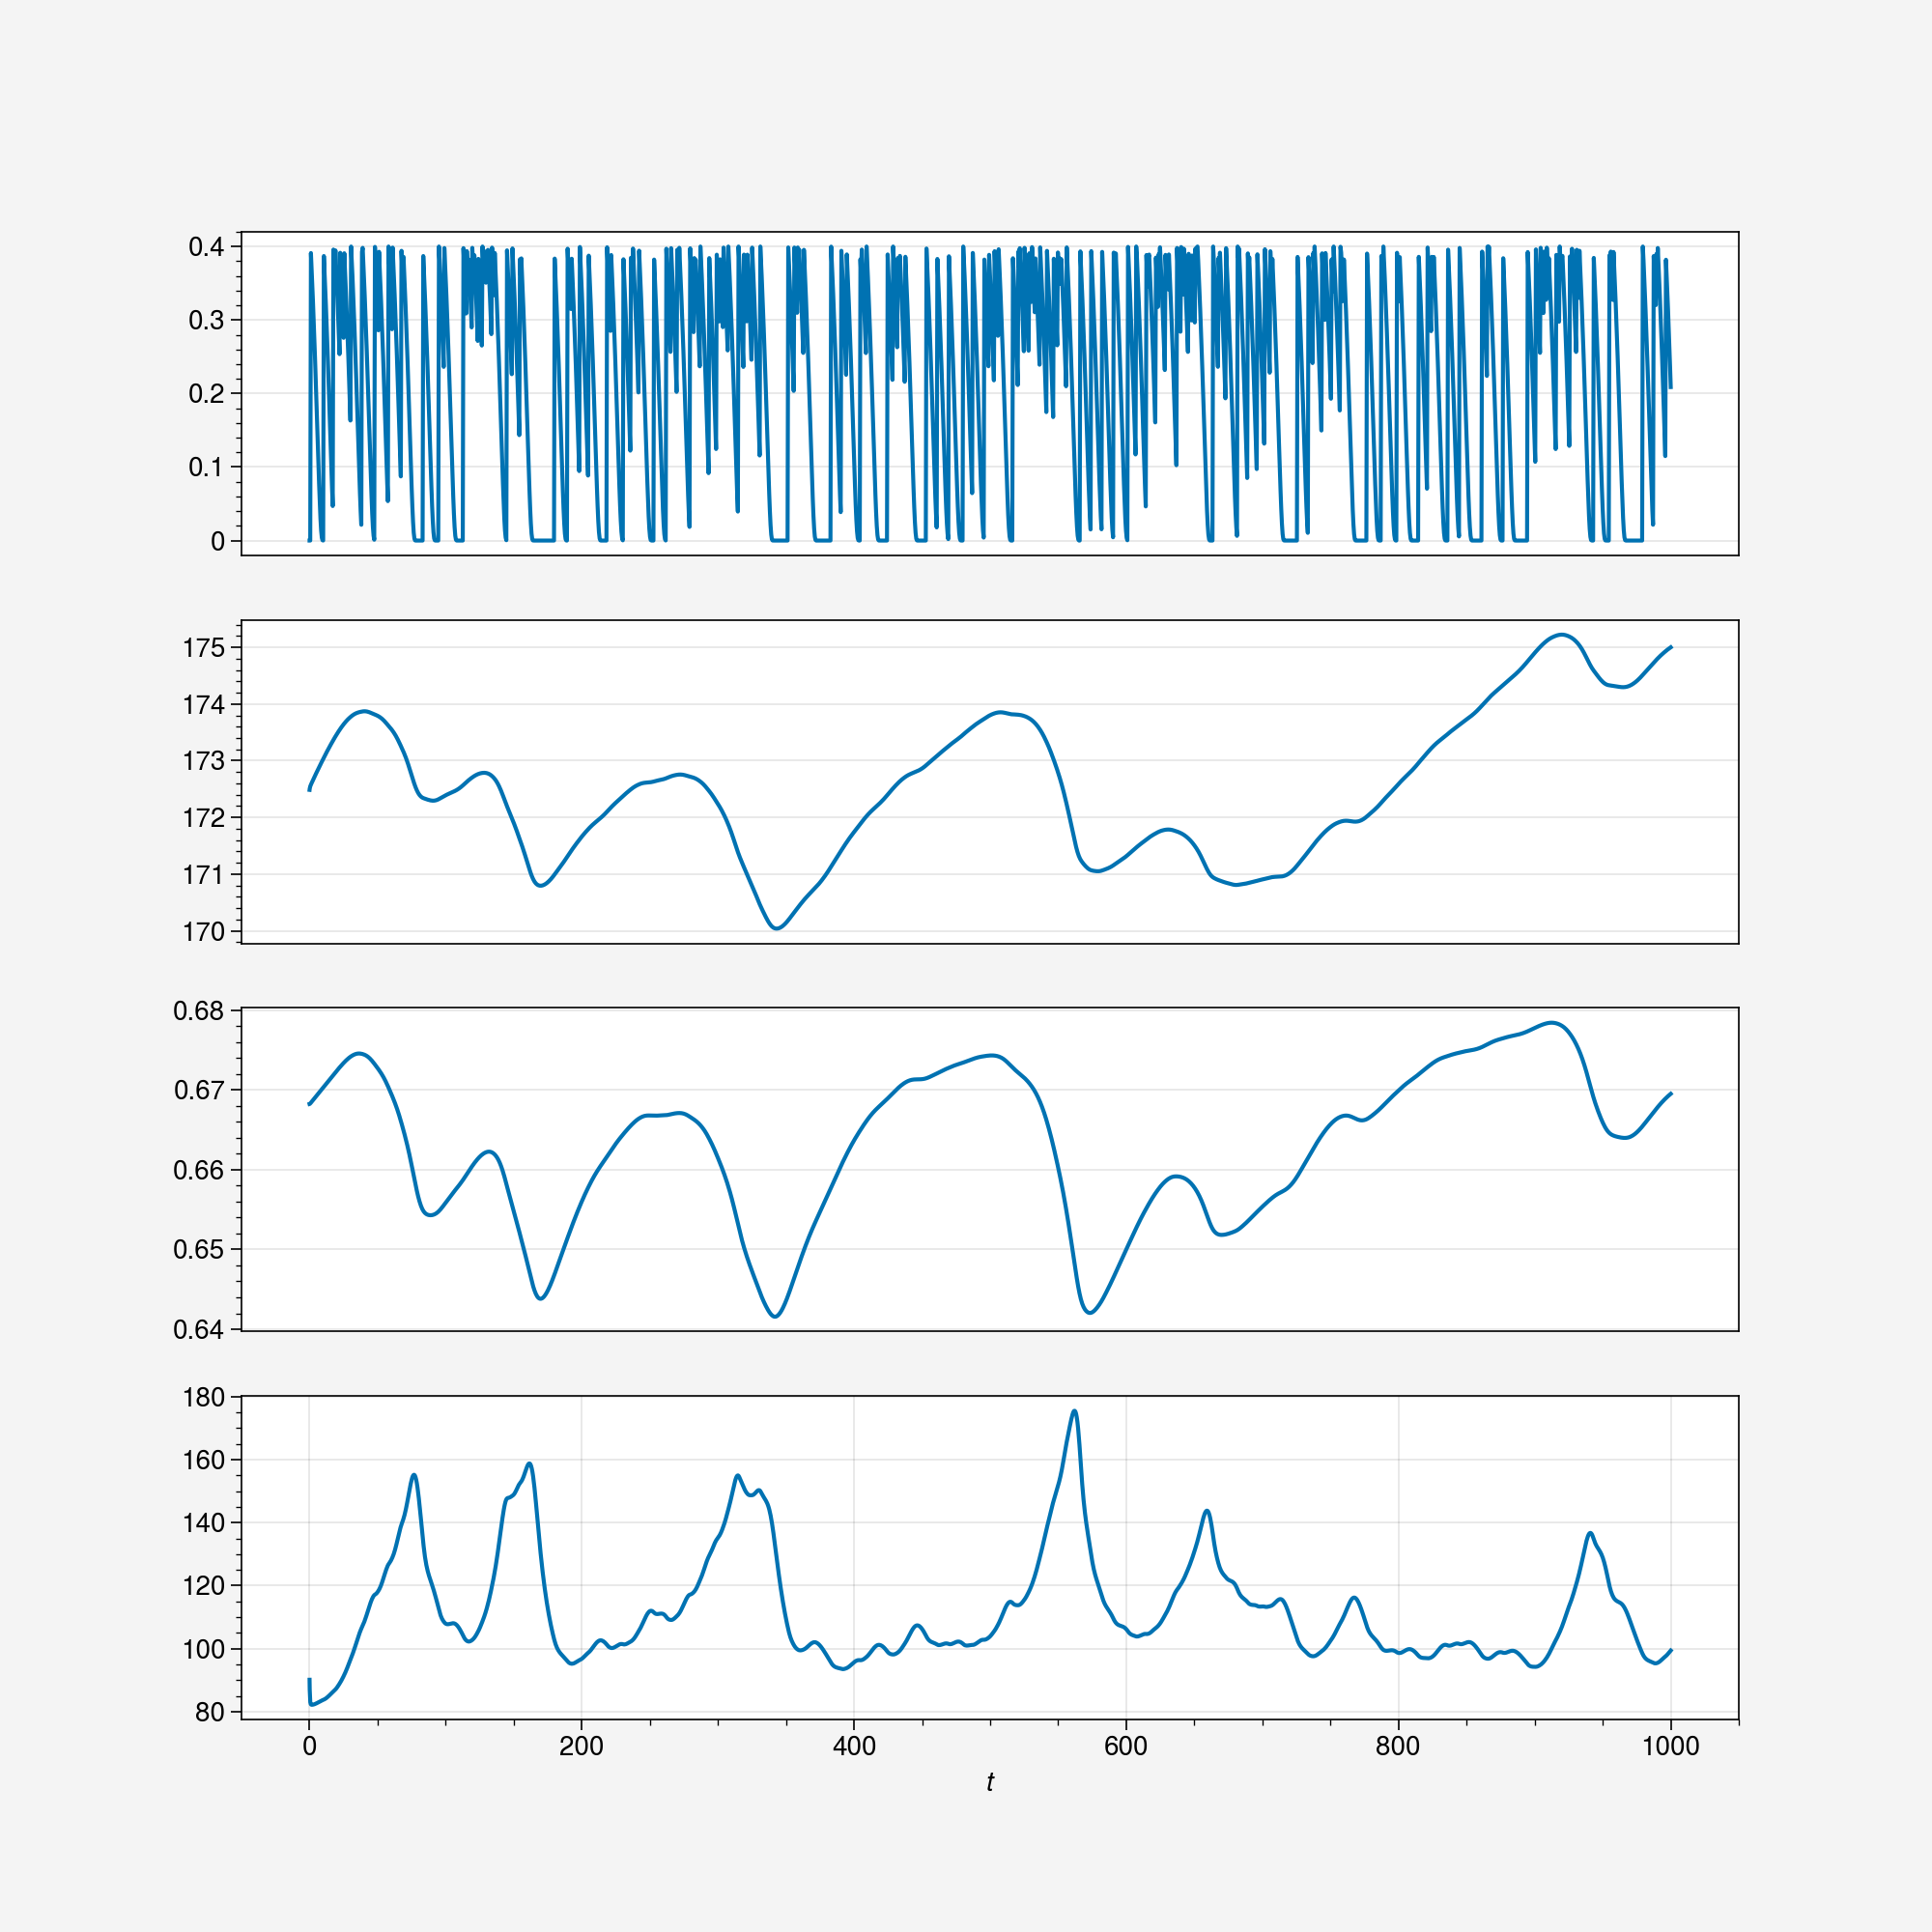

In [23]:
cfg.input_start = 0
cfg.input_duration = 0.06
cfg.input_max = 0.4

random.seed(1)
cfg.train = generate_train(0.2, t_f=2000)

set_init('c_t')

sol = run_experiment('exponential_train', max_step=0.5, t_f=1000)
plot_experiment_plots(['glut', 'c_er', 'h', 'c'])

## Distribution of c_er means

**Run 200 trials of poisson stimulation**

In [31]:
cfg.input_duration = 0.06
cfg.input_max = 0.4
set_init('c_t')

c_tots = []
c_ers = []
cs = []
hs = []
for i in tqdm(range(200)):
    random.seed(i)
    cfg.train = generate_train(0.2, t_f=2000)

    sol = run_experiment('exponential_train', max_step=10, t_f=1000)
    
    c_tots.append(np.mean(cfg.c_tot))
    c_ers.append(np.mean(cfg.c_er))
    cs.append(np.mean(cfg.c))
    hs.append(np.mean(cfg.h))
    
pickle.dump({'c_tots': c_tots,
             'c_ers': c_ers,
             'cs': cs,
             'hs': hs}, open('data/plot_data/oscillation_delay/poisson_stimulation_distribution', 'wb'))

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]C:\Users\14and\Desktop\Work\github\epilepsy_astrocytes2\Python\ip3_ca_ode_cfg.py:247: RuntimeWarning: invalid value encountered in double_scalars
  J_serca = cfg.v_serca * (c**1.75) / (c**1.75 + cfg.k_serca**1.75)
100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:50<00:00,  3.93it/s]


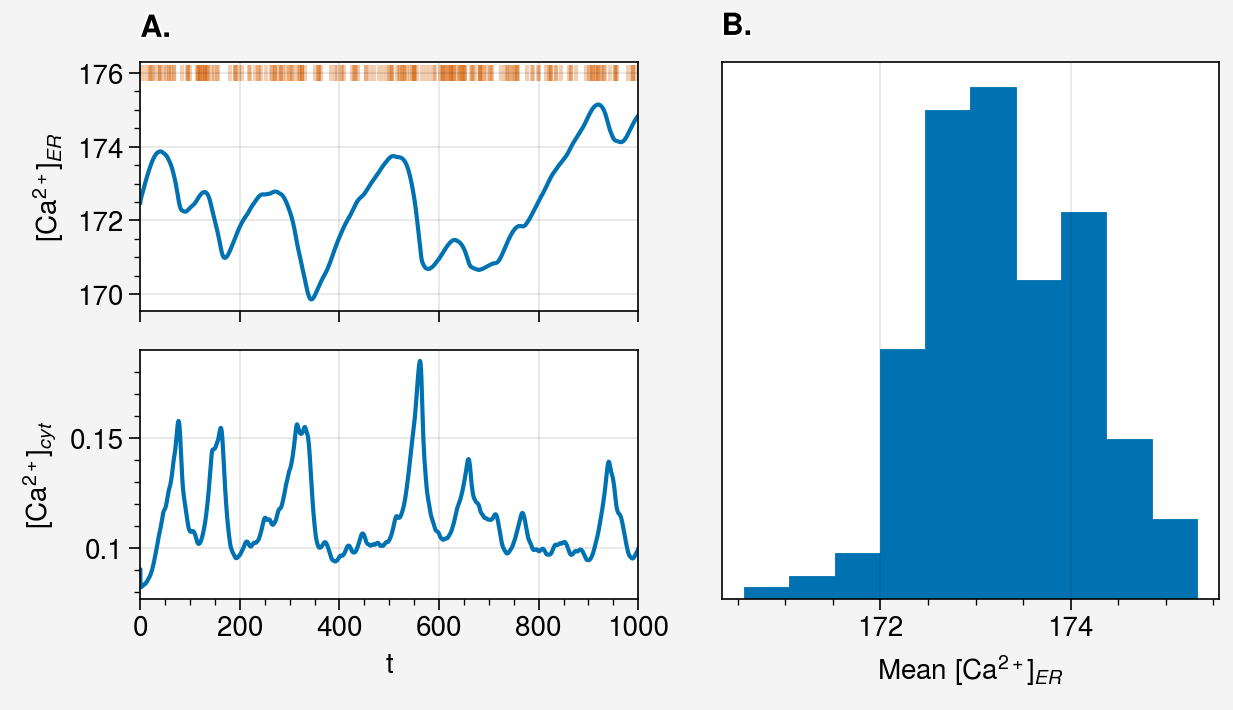

In [36]:
data = pickle.load(open('data/plot_data/oscillation_delay/poisson_stimulation_distribution', 'rb'))

array = [
    [1, 1, 3, 3],
    [2, 2, 3, 3]
]

fig, ax = pplt.subplots(array, refaspect=2, wspace=3, sharex=False, 
                        sharey=False, figwidth=7)

cfg.input_start = 0
cfg.input_duration = 0.06
cfg.input_max = 0.4

# Plot example poisson stimulation
random.seed(1)
cfg.train = generate_train(0.2, t_f=2000)
sol = run_experiment('exponential_train', max_step=1, t_f=1000)


ax[0].plot(cfg.t, cfg.c_er)
ax[1].plot(cfg.t, cfg.c)
ax[0].scatter(cfg.train, np.full(cfg.train.shape, 176), marker='|',
              alpha=0.3)

# Plot c_er distributions
ax[2].hist(data['c_ers'])

ax[:2].format(xlabel='t')
ax[0].format(xticklabels=[], ylabel=c_er_label,
            xlim=[0, 1000], xlabel='')
ax[1].format(ylabel=c_label)
ax[2].format(xlabel=r'Mean [Ca$^{2+}$]$_{ER}$', yticks=[])

add_abc_to_subaxes(ax[0], top=1.1)
add_abc_to_subaxes(ax[2], 'B.')

<a list of 1 Line2D objects>

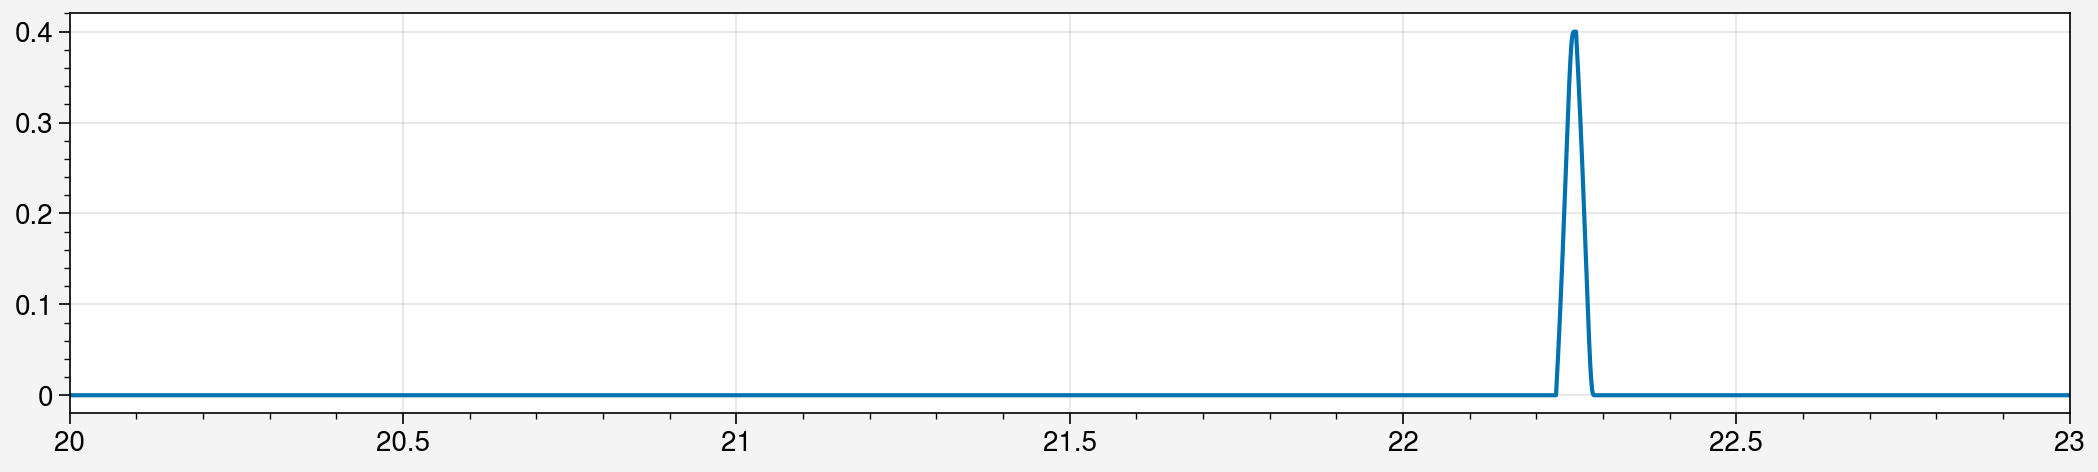

In [24]:
fig, ax = pplt.subplots(refaspect=5, refwidth=10)
ts = np.linspace(20, 23, 50000)
# y = [exponential_input(t) for t in ts]
y = [exponential_train(t) for t in ts]
ax.plot(ts, y)

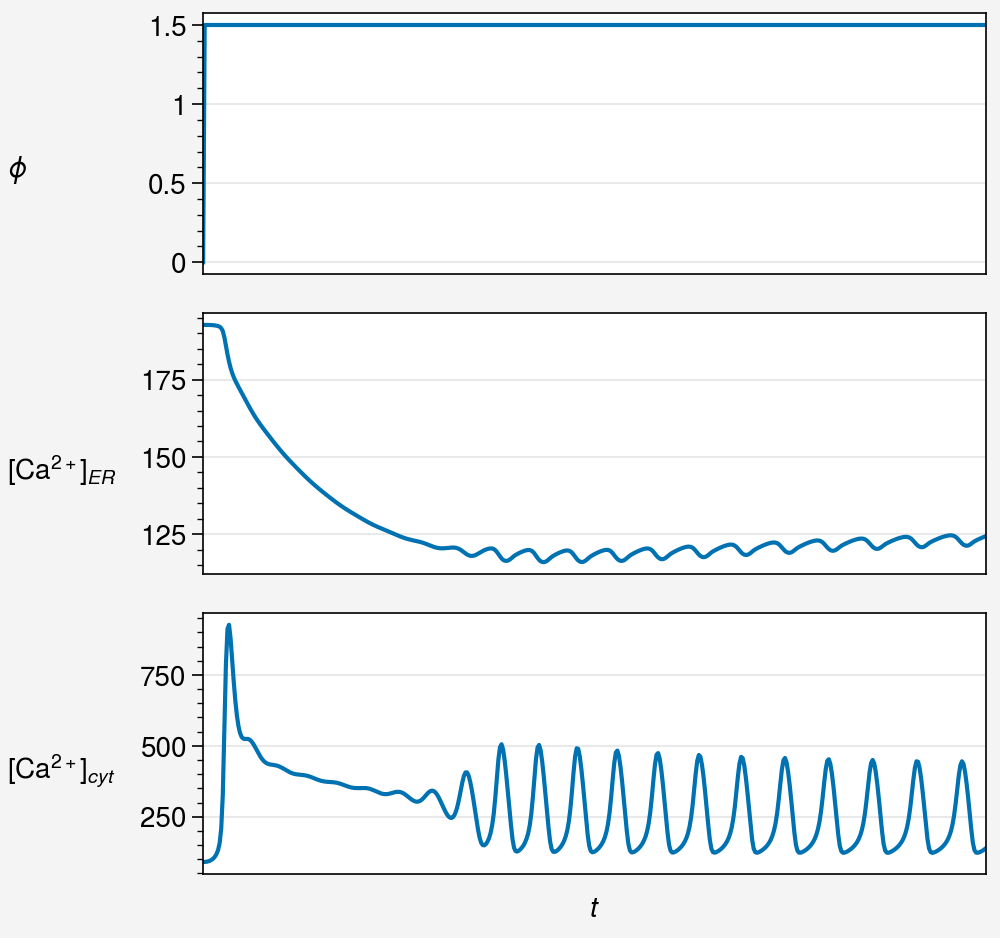

In [40]:
cfg.input_max = 1.5
cfg.input_duration = 600
run_experiment('pulse', t_f=500, max_step=1)
# plt.plot(cfg.t, cfg.c)
fig, ax = pplt.subplots(nrows=3, refaspect=3, sharey=False, figwidth=5)
plot_experiment_plots(['glut', 'c_er', 'c'], axs=ax,  ylabel_padding=[-0.25, 0.4])